# Introduction: the BSM model

#### Roland Grinis  -  Researcher at MIPT Nuclear Physics Methods lab  -  CTO at GrinisRIT (grinisrit.com)

In [3]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(987654);

If you like dark plots:

In [4]:
import seaborn as sns
sns.set_style('darkgrid',
                {'axes.facecolor': '.2',
                'figure.facecolor': '0.1',
                'text.color': '.9',
                'grid.color': '.5',
                'xtick.color': '.9',
                'ytick.color': '.9'})

## 1. Introduction

### 1.1 What are *derivatives*?

Assets include bonds, stocks, commodities, FX rates, cryptocurrencies etc. 

Some examples:

#### Zero-coupon bond
A contract worth $P(t,T)$ at time $t$ that pays $P(T,T) = 1$ at maturity $t=T$

In [5]:
N = 365 # Actual/365 day counting convention
t = torch.linspace(0,1,N) # in years, maturity T = 1
time_to_maturity = 1 - t

Continuously-compounded spot interest rate 
$$
r(t,T) = - \frac{\ln P(t,T)}{T-t}
$$

In [6]:
spot_interest_rate = 0.01 * torch.rand(N) + 0.05 * torch.sigmoid(100 * (t-0.5))  # rate hike
bond = torch.exp(- time_to_maturity * spot_interest_rate)

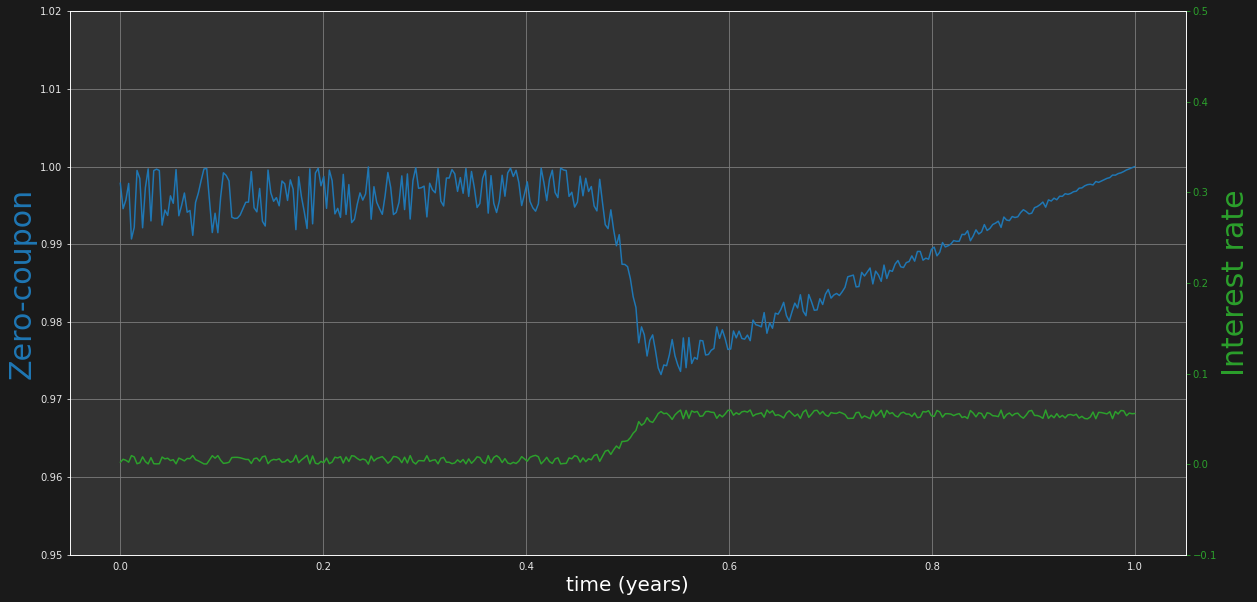

In [69]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_xlabel('time (years)', color='white', fontsize=20)
ax1.set_ylabel('Zero-coupon', color='C0', fontsize=30)
ax1.plot(t.numpy(), bond.numpy(), 'C0')
ax1.set_ylim([0.95,1.02])

ax2 = ax1.twinx() 
ax2.grid(False)
ax2.set_ylabel('Interest rate', color='C2', fontsize=30)
ax2.plot(t.numpy(),spot_interest_rate.numpy(),color='C2')
ax2.set_ylim([-0.1,0.5])
ax2.tick_params(axis='y', colors='C2')

plt.show()

#### Zero-bond curve 
This is the map:

$$
T \rightarrow P(t,T), \quad T>t
$$ 

with corresponding continuously-compounded zero-coupon curve:

$$
T \rightarrow r(t,T), \quad T>t
$$ 

sometimes simply referred to as the *yield curve*. 

There are many different curves, e.g.
[US Libor](https://tradingeconomics.com/united-states/interbank-rate),
[US Treasuries](https://tradingeconomics.com/united-states/government-bond-yield) etc.



#### Risky assets
Stock prices $S(t)$ and everything else is classified as *risky*. At the beginning of 20th century Bachelier proposed to model them as Browmian motion:

In [60]:
S = 100 + (0.5 + 5.*torch.randn(N)).cumsum(0) # alpha = 0.5 and vol = 5.0

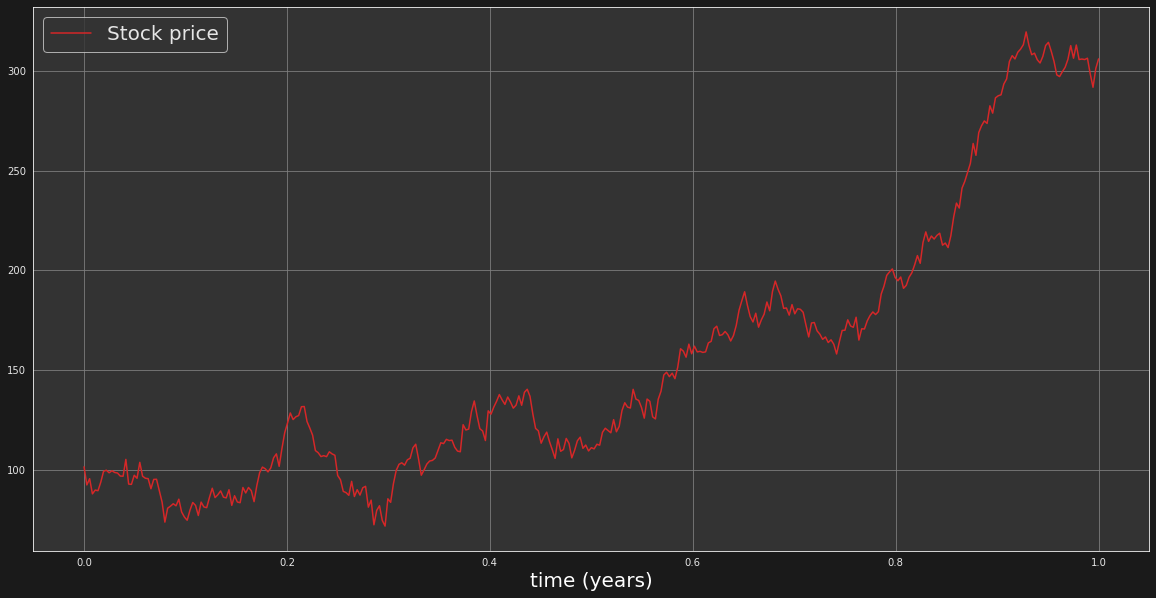

In [67]:
plt.figure(figsize=(20,10))
plt.plot(t.numpy(), S.numpy(),'C3',markersize=30, label='Stock price')
plt.legend(fontsize=20)
plt.xlabel('time (years)', color='white', fontsize=20)
plt.show()

Mandelbrot noted in the 1960s that Brownian motion fails to produce *fat tails* typically observed in stock returns distribution. Modelling improvements include *stochastic volatility* and *jump processes*.

#### Financial Derivatives
It is a contract between a Party (P) and its Counter-Party (CP) entered at time $t=t_0$ and settleted:
* at maturity $t=T$ (European style)
* at any time $t \leq T$ (American style)
* at some specified exercise dates $t_1, t_2, \dots, T$ (Bermudan style)

according to a *payoff* function that depends on one or several underlying securities (assets, or other derivatives). 

The payoff might depend on the value of the underlyings at exercise date (vanilla contracts) or on the whole path between $t_0$ and maturity $T$ (exotic contracts).


### Who are *quants*?

Front office: 
* quant traders
* strategist (strats)
* quant modellers 
* quant developers

Back office:
* risk management
* regulatory 

## References

* Seydel, R.U. *Tools for Computational Finance*, 6th edition, Springer V., London (2017)
* Shreve, S.E. Stochastic Calculus for Finance I & II, Springer, New York (2004)
* Grzelak, L.A. et al. *Mathematical Modeling and Computation in Finance: With Exercises and Python and MATLAB Computer Codes*, World Scientific Pub. (2019)